In [1]:
import os

import numpyro.distributions as dist
import pandas as pd
from jax import random
from PIL import Image

from splotch import get_input_data, run_nuts
from splotch.models import get_default_priors
from splotch.visualization import (
    plot_variable_on_slides,
)

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

Image.MAX_IMAGE_PIXELS = 1000000000

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
splotch_input_data = get_input_data(
    "metadata.tsv", 3, min_detection_rate=0.1, num_of_neighbors=8
)

Discarding a tissue section with 1 spots
Discarding a tissue section with 1 spots
Discarding a tissue section with 2 spots
Discarding a tissue section with 1 spots
Discarding a tissue section with 2 spots
Discarding a tissue section with 2 spots
Discarding a tissue section with 1 spots
Discarding a tissue section with 1 spots
Discarding a tissue section with 8 spots
Discarding 1 spots due to low sequencing depth.
Discarding a tissue section with 1 spots


## NUTS


### Default priors


In [3]:
print(get_default_priors.__doc__)  # noqa: T201

Get default priors.

    The default priors are:
        alpha ~ Gamma(2, 2),
        length ~ Gamma(10, 10),
        theta ~ Beta(1, 2),
        sigma_spot ~ HalfNormal(0.3).

    Returns:
        Prior distributions.
    


In [4]:
key = random.PRNGKey(0)
key, key_ = random.split(key)

splotch_result_nuts = run_nuts(
    key_,
    ["Slc5a7"],
    splotch_input_data,
    map_method="pmap",
    num_warmup=1_000,
    num_samples=1_000,
    num_chains=4,
)

In [5]:
pd.concat(
    [
        splotch_result_nuts.inference_metrics["summary"][k].query("r_hat > 1.05")
        for k in splotch_result_nuts.inference_metrics["summary"]
    ],
    axis=0,
)

,,mean,std,median,5.0%,95.0%,n_eff,r_hat
gene,index,,,,,,,


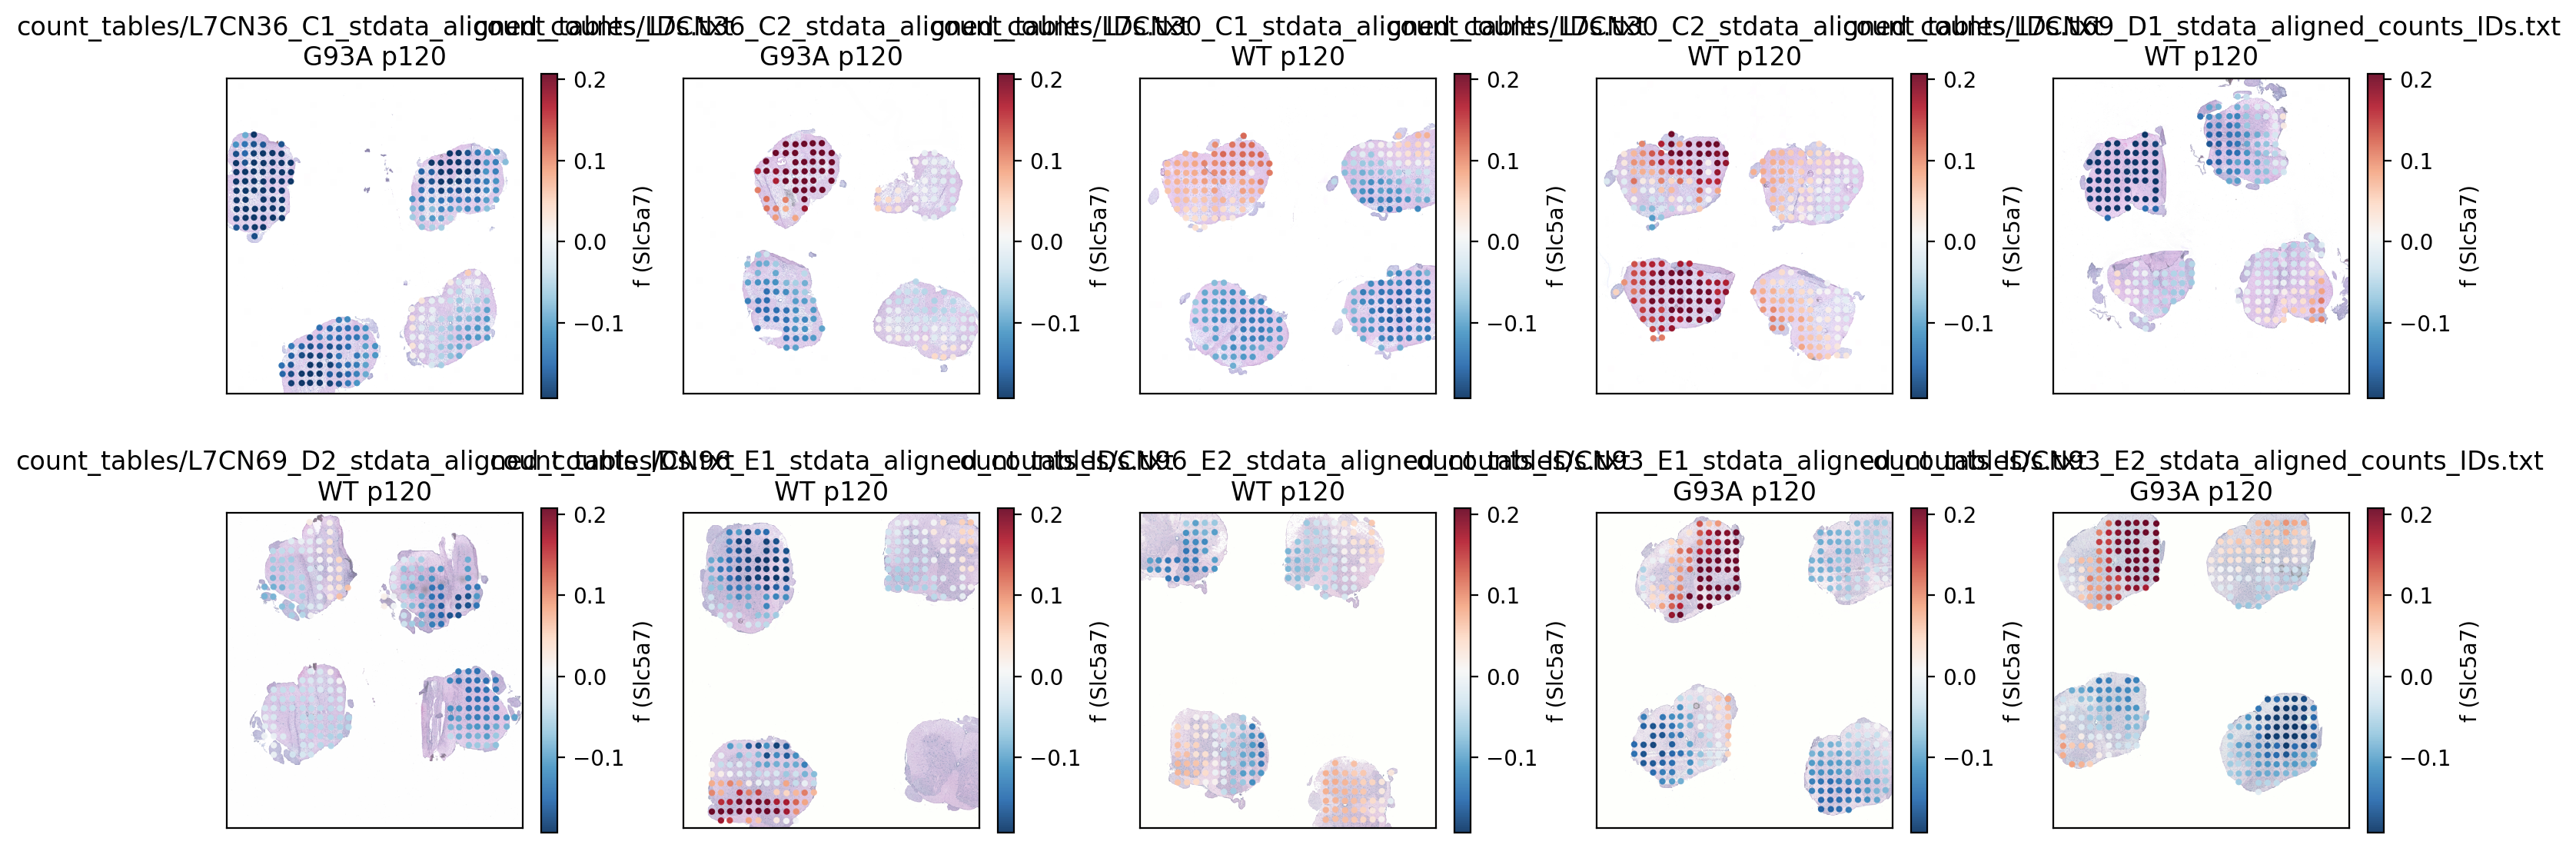

In [6]:
gene = "Slc5a7"

_ = plot_variable_on_slides(splotch_result_nuts, gene, "f")

### Modified priors

Assume slowly changing spatial random effects a priori.


In [7]:
priors = {"length": dist.Gamma(10, 1)}

In [8]:
key = random.PRNGKey(0)
key, key_ = random.split(key)

splotch_result_nuts = run_nuts(
    key_,
    ["Slc5a7"],
    splotch_input_data,
    map_method="pmap",
    num_warmup=1_000,
    num_samples=1_000,
    num_chains=4,
    priors=priors,
)

E1025 12:53:06.036644 36185209 collective_ops_utils.h:279] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{rank=1, element_count=13572000, type=F32, rendezvous_key=RendezvousKey{run_id=RunId: 5689, global_devices=[0,1,2,3], num_local_participants=4, collective_op_kind=cross_replica, op_id=474}} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 5689, global_devices=[0,1,2,3], num_local_participants=4, collective_op_kind=cross_replica, op_id=474}
E1025 12:53:06.053530 36185214 collective_ops_utils.h:279] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{rank=3, element_count=13572000, type=F32, rendezvous_key=RendezvousKey{run_id=RunId: 5689, global_devices=[0,1,2,3], num_local_participants=4, collective_op_kind=cross_replica, op_id=474}} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 5689, global_devices=[0,1,2,3], num_local

In [9]:
pd.concat(
    [
        splotch_result_nuts.inference_metrics["summary"][k].query("r_hat > 1.05")
        for k in splotch_result_nuts.inference_metrics["summary"]
    ],
    axis=0,
)

,,mean,std,median,5.0%,95.0%,n_eff,r_hat
gene,index,,,,,,,


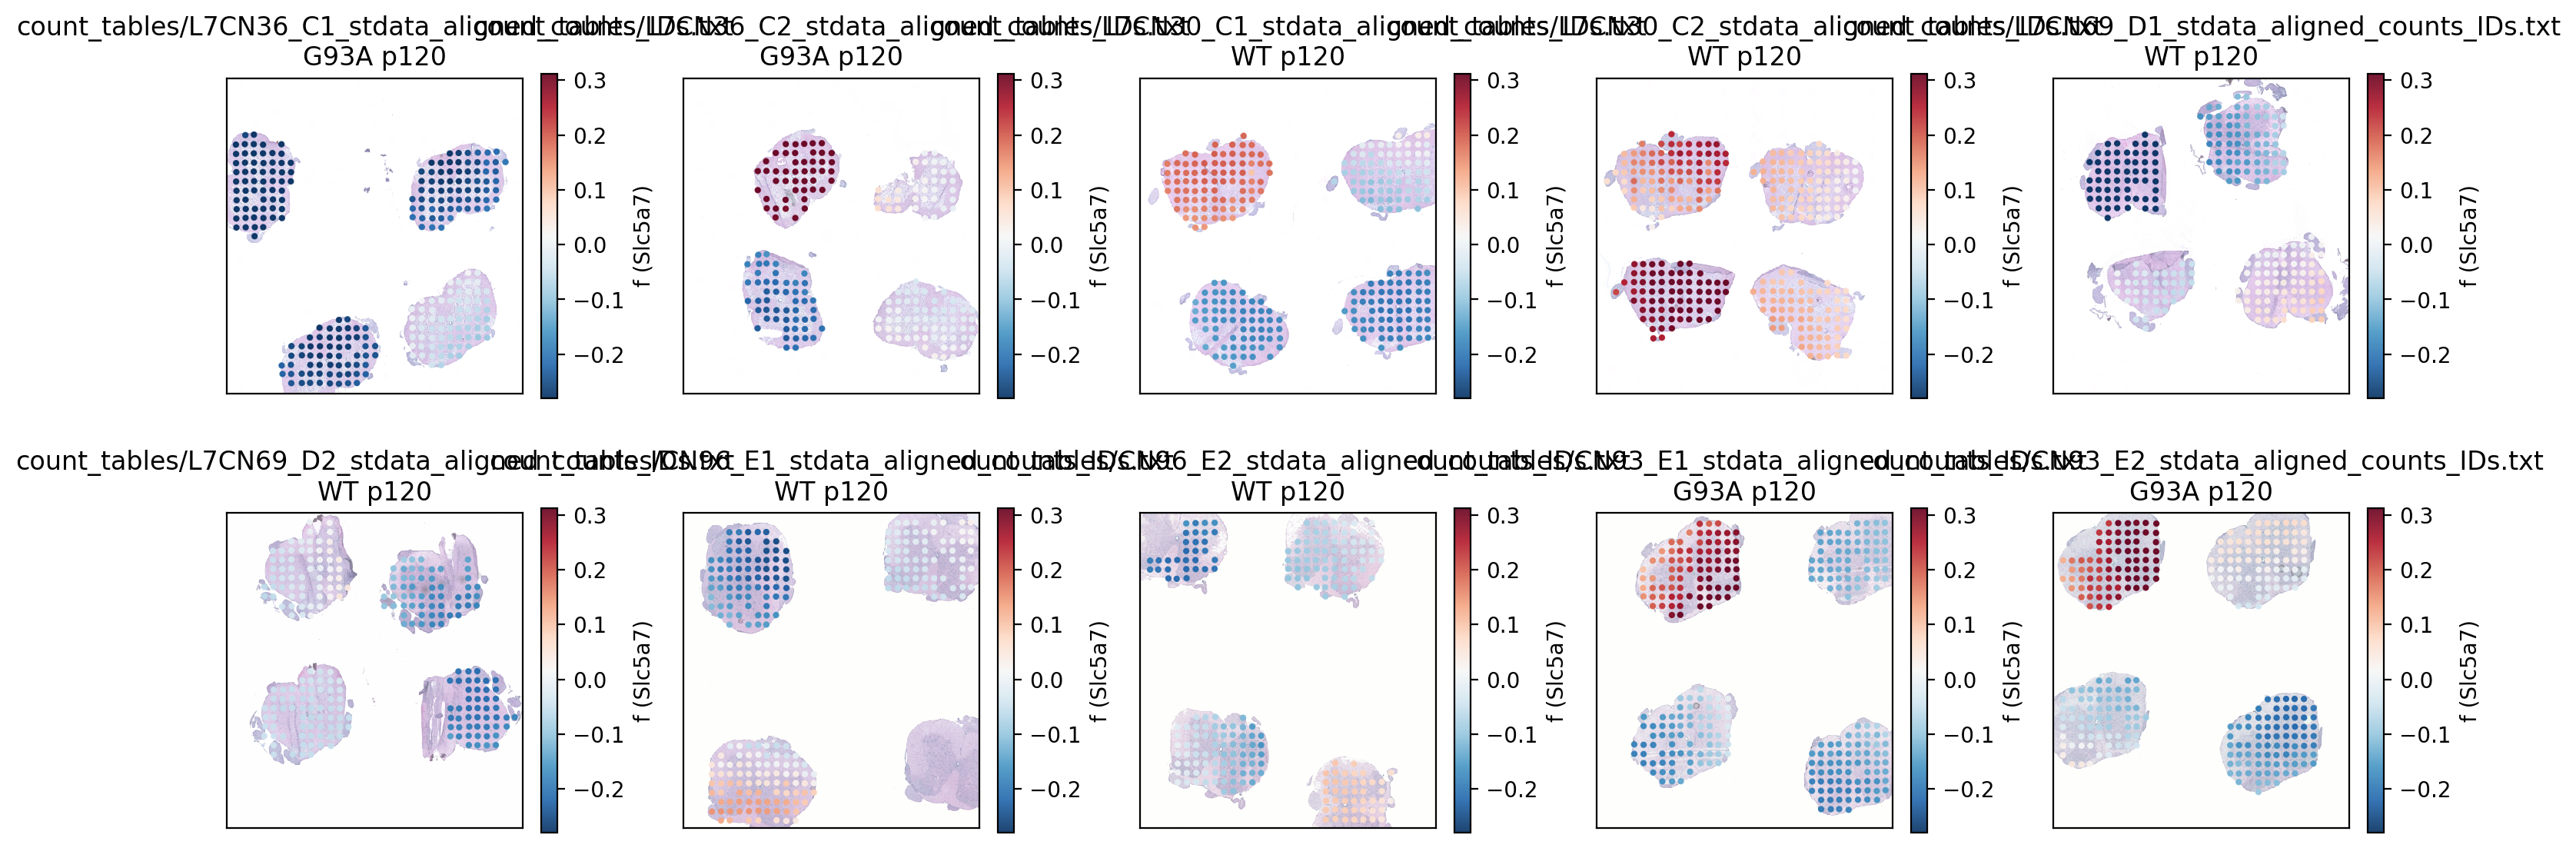

In [10]:
gene = "Slc5a7"

_ = plot_variable_on_slides(splotch_result_nuts, gene, "f")